<a href="https://colab.research.google.com/github/lukasoares/Model_to_predict_stroke/blob/main/Notebook_1%20_Tratamento_e_limpeza_dos_dados/%20DataStrokeWithPysparkSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Iniciando o Spark no Google Colab:

In [1]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("DataStrokeWithPysparkSQL") \
    .getOrCreate()

In [5]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00


In [6]:
from pyspark.sql.types import DoubleType, StringType
from pyspark.sql import functions as f
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
import numpy as np


##Importando a base de dados

In [7]:
data= spark.read.csv('/content/drive/MyDrive/base_de_dados/Stroke-data/healthcare-dataset-stroke-data.csv', header = True, inferSchema = True)

In [8]:
data.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

Como podemos ver, essa base de dados contém os tipos das colunas já categorizados de maneira apropriada, com excessão da categória "bmi". Foi feita a transformação dessa coluna para "DoubleType"

In [9]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [10]:
data = data.withColumn('bmi', data['bmi'].cast(DoubleType()))
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [11]:
data.count()

5110

In [12]:
len(data.columns)

12

##Limpeza dos dados

Primeiro vamos tentar localizar os dados nulos de todas as colunas, utilizando um loop que soma 1 (ou True) se a coluna contém um dado nulo ou N/A.

In [13]:
data.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in data.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



Foram localizados 201 dados nulos na coluna "bmi". Para a subtituição dessa valores foi utilizado a mediana. Para facilitar o processo, utilizei a função toPandas() para conseguir a mediana de maneira mais fácil.

In [21]:
data_modi = data.withColumn("bmi", f.when(f.isnull('bmi'), data.toPandas().bmi.median()).otherwise(data["bmi"]))

In [22]:
data_modi.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.1|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

"Com a classe "createOrReplaceTempView", é possível criar uma "view" no "pyspark.sql" que permite fazer consultas utilizando a linguagem SQL."

In [23]:
data_modi.createOrReplaceTempView("dataView")

Após uma observação mais atenciosa, foi localizado 1544 dados "Unknown" da coluna "smoking_status". Como se trata de uma "coluna" muito relevante para a nossa análise e de um volume de dados muito representativo, foi escolhida a sua manutenção.

In [24]:
for c in ["gender", "ever_married",  "work_type", "Residence_type", "smoking_status"]:
  spark.sql(f"SELECT DISTINCT({c}) FROM dataView").show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+

+------------+
|ever_married|
+------------+
|          No|
|         Yes|
+------------+

+-------------+
|    work_type|
+-------------+
| Never_worked|
|Self-employed|
|      Private|
|     children|
|     Govt_job|
+-------------+

+--------------+
|Residence_type|
+--------------+
|         Urban|
|         Rural|
+--------------+

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



In [20]:
spark.sql('SELECT count(*) from dataView WHERE smoking_status == "Unknown"').show()

+--------+
|count(1)|
+--------+
|    1544|
+--------+



#Análise dos Dados Qualitativos

In [25]:
df = data_modi.toPandas()

##Análise por Gêneros da Coluna "stroke"
Inicialmente, realizou-se a análise da ocorrência de AVCs separando os indivíduos por gênero. Foram avaliados os dados das pessoas que já sofreram ataque cardíaco e os que nunca sofreram, para que fosse possível identificar possíveis diferenças entre os gêneros.

In [26]:
def qualitative_results(column, number_stroke):
   return spark.sql(f"SELECT {column}, COUNT(stroke) AS Contagem_Stroke{number_stroke}, ROUND(COUNT(stroke) / (SELECT COUNT(*) FROM dataView WHERE stroke = {number_stroke}), 2) *100 AS Proportion_Stroke_{number_stroke}_{column} FROM dataView WHERE stroke = {number_stroke} GROUP BY {column}").toPandas()

In [27]:

def qualitativeGraphics(column, list_rename_category):
  fig = make_subplots(rows=1, cols=2, shared_yaxes=True, vertical_spacing=0.4, horizontal_spacing=0.1, subplot_titles = ["Did not have a stroke", "Had a stroke"])
  df = qualitative_results(column = column , number_stroke =1)
  df2 = qualitative_results(column = column , number_stroke =0)
  if list_rename_category is not None:
    df[column] = list_rename_category
    df2[column] = list_rename_category
  fig.add_trace(go.Bar(y=df[column], x= df[f"Proportion_Stroke_{1}_{column}"] , orientation='h'), row=1, col=1)
  fig.add_trace(go.Bar(y=df2[column], x= df2[f"Proportion_Stroke_{0}_{column}"] , orientation='h'), row=1, col=2)
  fig.update_xaxes(title = f"(%) From a total of {df.Contagem_Stroke1.sum()} individuals", row=1, col=1).update_xaxes(title = f"(%) From a total of {df2.Contagem_Stroke0.sum()}", row=1, col=2)
  fig.update_layout(height=400, width=800, template="plotly_dark", showlegend=False, margin=dict(t=50, r =50))
  fig.show('png')


In [28]:
qualitative_results("Gender", 1)

,Gender,Contagem_Stroke1,Proportion_Stroke_1_Gender
0,Female,141,57.0
1,Male,108,43.0


In [29]:
qualitative_results("Gender", 0)

,Gender,Contagem_Stroke0,Proportion_Stroke_0_Gender
0,Female,2853,59.0
1,Other,1,0.0
2,Male,2007,41.0


In [36]:
spark.sql("SELECT gender, count(gender) from dataView group by gender").show()

+------+-------------+
|gender|count(gender)|
+------+-------------+
|Female|         2994|
| Other|            1|
|  Male|         2115|
+------+-------------+



Analisando o gráfico abaixo, podemos notar que as mulheres dessa amostragem sofreram mais AVCs que os homens em número absoluto. Porém, os homens dessa amostra apresentam uma taxa de infarto de 5,10% (1808/2115), já as mulheres de 4,94% (141/2853).

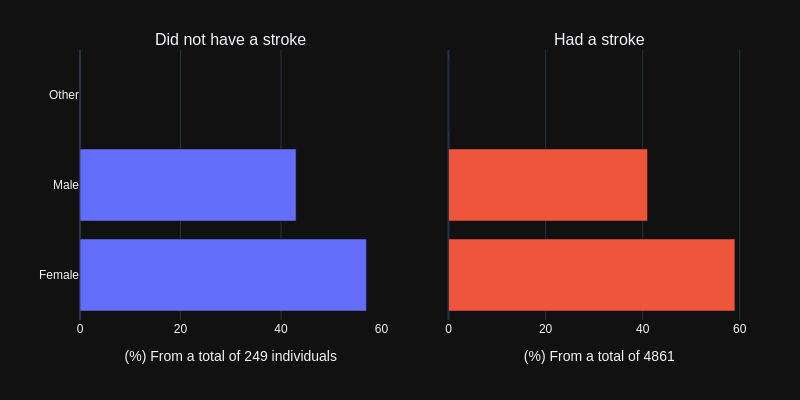

In [30]:
qualitativeGraphics("Gender", list_rename_category = None)

##Análise da variável "smoking_status"
A análise dessa variável foi feita em relação à variável dependente "stroke" para analisar a possível influência dessa variável nos derrames.

In [37]:
qualitative_results("smoking_status", 0)

,smoking_status,Contagem_Stroke0,Proportion_Stroke_0_smoking_status
0,smokes,747,15.0
1,Unknown,1497,31.0
2,never smoked,1802,37.0
3,formerly smoked,815,17.0


In [38]:
qualitative_results("smoking_status", 1)

,smoking_status,Contagem_Stroke1,Proportion_Stroke_1_smoking_status
0,smokes,42,17.0
1,Unknown,47,19.0
2,never smoked,90,36.0
3,formerly smoked,70,28.0


Ao analisar o gráfico abaixo, é possível observar uma diferença considerável na taxa de indivíduos que nunca fumaram e fumam socialmente entre os grupos que tiveram e não tiveram AVC.

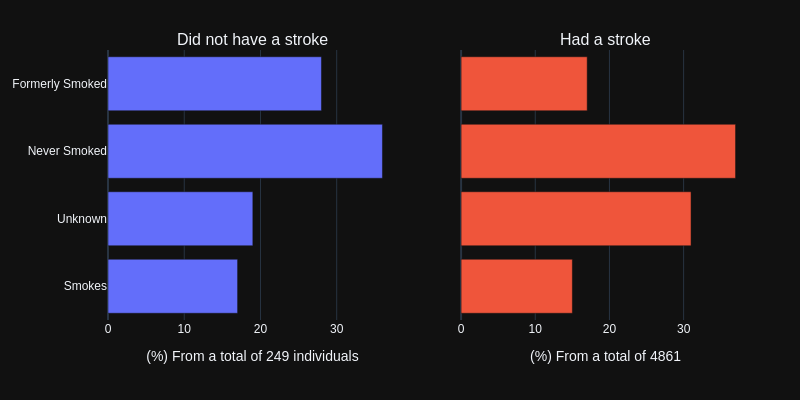

In [40]:
qualitativeGraphics("smoking_status", list_rename_category = ["Smokes", "Unknown", "Never Smoked", "Formerly Smoked"])

##Análise da Variável "Hypertension"

In [41]:
qualitative_results("Hypertension", 0)

,Hypertension,Contagem_Stroke0,Proportion_Stroke_0_Hypertension
0,1,432,9.0
1,0,4429,91.0


In [42]:
qualitative_results("Hypertension", 1)

,Hypertension,Contagem_Stroke1,Proportion_Stroke_1_Hypertension
0,1,66,27.0
1,0,183,73.0


Como pode-se observar pelos gráficos abaixo, a proporção de pessoas que são hypertensas é maior no grupo amostral de pessoas que tiveram ataque cardíaco (27 % contra 9%).

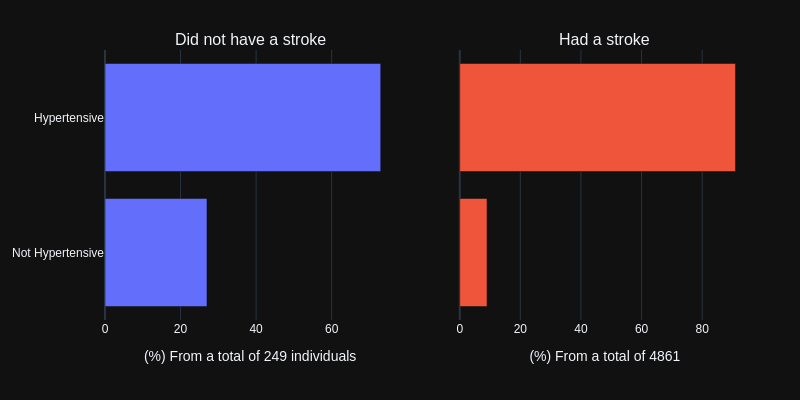

In [43]:
qualitativeGraphics("Hypertension", list_rename_category = ["Not Hypertensive", "Hypertensive"])

##Análise da variável "heart_disease"

In [44]:
qualitative_results(column = "heart_disease", number_stroke =1)

,heart_disease,Contagem_Stroke1,Proportion_Stroke_1_heart_disease
0,1,47,19.0
1,0,202,81.0


In [45]:
qualitative_results(column = "heart_disease", number_stroke = 0)

,heart_disease,Contagem_Stroke0,Proportion_Stroke_0_heart_disease
0,1,229,5.0
1,0,4632,95.0


In [46]:
qualitative_results("heart_disease" , number_stroke =1)

,heart_disease,Contagem_Stroke1,Proportion_Stroke_1_heart_disease
0,1,47,19.0
1,0,202,81.0


Neste gráfico pode-se chegar a conclusão que as pessoas que tiverem AVC apresentam uma maior taxa de pessoas que tem doença no coração (19% contra 5%).

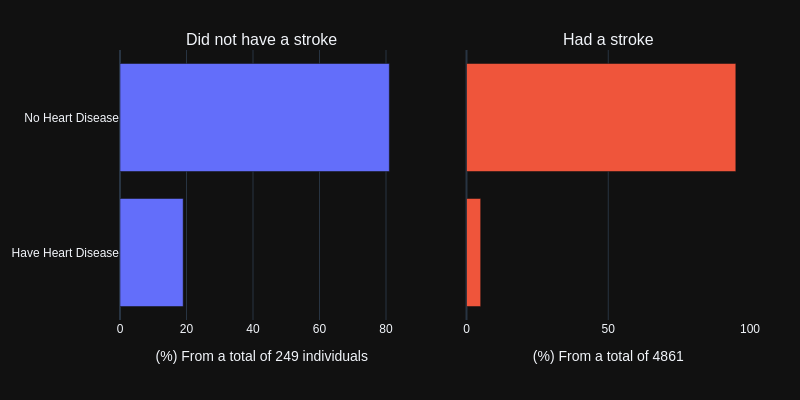

In [47]:
qualitativeGraphics("heart_disease", list_rename_category = ["Have Heart Disease", "No Heart Disease"])

#Análise das Variáveis Quantitativas

Pela análise gráfica, a variável 'age' apresenta uma distribuição parecida com a normal, apesar do aumento da frequência ao chegar na faixa dos 80 anos. Já as outras duas variáveis, "avg_glucose_level" e "bmi", apresentam uma distribuição assimétrica para a direita.

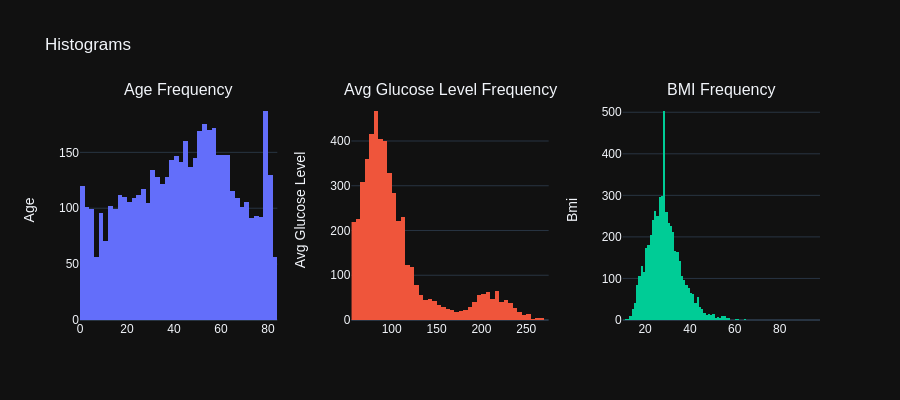

In [48]:
column_list_numerics = ['age', 'avg_glucose_level', 'bmi']
fig = make_subplots(rows=1, cols=3, subplot_titles = ['Age Frequency', 'Avg Glucose Level Frequency', 'BMI Frequency'], horizontal_spacing=0.1)
count = 0
for i in column_list_numerics:
  count +=  1
  fig.add_trace(go.Histogram(x = df[i]),row=1, col=count).update_yaxes(title = i.title().replace('_', ' '), row=1, col=count)
fig.update_layout(title_text="Histograms", height=400, width=900, template="plotly_dark", showlegend=False)
fig.show('png')


In [ ]:
len(df.columns)

12

#Análise da coluna "avg_glucose_level"
Foi analisado o nível de glicose médio no sangue separando também por grupos de gênero.
Os homens apresentaram uma média maior que das mulheres.

In [49]:
spark.sql('SELECT gender, avg(avg_glucose_level) FROM dataView GROUP BY gender').show()

+------+----------------------+
|gender|avg(avg_glucose_level)|
+------+----------------------+
|Female|    104.05780895123563|
| Other|                143.33|
|  Male|     109.0885200945626|
+------+----------------------+



Foi necessário verificar essa informação estatisticamente. Para escolhermos o teste adequado, primeiro foi preciso realizar um teste de normalidade para avaliar a distribuição da variável "avg_glucose_level". O resultado estatístico indicou que a hipótese nula de normalidade foi rejeitada, o que significa que com 99% de confiança, não podemos afirmar que essa variável segue uma distribuição normal.

In [50]:
def normal_test(array, alpha):
  stat_test, p_value = kstest(array, 'norm')
  alpha = 0.01
  if p_value < alpha:  
      print("The null hypothesis can be rejected. It's not a normal distribution")
  else:
      print("The null hypothesis cannot be rejected. It's a normal distribution")


In [51]:
df_glucose = spark.sql('SELECT avg_glucose_level from dataView').toPandas()
normal_test(df_glucose['avg_glucose_level'], alpha = 0.01)

The null hypothesis can be rejected. It's not a normal distribution


Foram criados DataFrames do Pandas separando os dados de glicose médio por gênero:

In [52]:
glucose_male = spark.sql('SELECT avg_glucose_level from dataView where gender == "Male"').toPandas()
glucose_female = spark.sql('SELECT avg_glucose_level from dataView where gender == "Female"').toPandas()

Como se trata de uma distruição não normal, foi escolhido o teste não paramétrico de média para amostras independentes Mann Whitneyu da biblioteca Scipy, utilizando o teste de calda superior.

### $H_0: \mu_{GB} = \mu_{RF}$

### $H_1: \mu_{GB} > \mu_{RF}$

In [53]:
def test_mean(array1, array2, alternative, alpha):
  U1, p_value = mannwhitneyu(glucose_male, glucose_female, alternative ="greater")
  if p_value < alpha:
      print("The null hypothesis can be rejected. The means are not igual.")
  else:
      print("The null hypothesis cannot be rejected. The means are igual.")

In [54]:
test_mean(glucose_male, glucose_female, 'greater', alpha = 0.01)

The null hypothesis can be rejected. The means are not igual.


Podemos afirmar estatisticamente com 99% de confiança que os homens dessa amostra tem em média uma glicose média maior.

Foi feito também um teste de hipótese de média para testar se a média de glicose de quem já teve infarto é maior de quem já teve.

In [55]:
spark.sql('SELECT stroke, avg(avg_glucose_level) as avg_glucose_level_had_stroke from dataView group by stroke').show()

+------+----------------------------+
|stroke|avg_glucose_level_had_stroke|
+------+----------------------------+
|     1|          132.54473895582322|
|     0|          104.79551326887444|
+------+----------------------------+



In [56]:
glucose_level_stroke1= spark.sql('SELECT avg_glucose_level from dataView where stroke == 1').toPandas()
glucose_level_stroke0= spark.sql('SELECT avg_glucose_level from dataView where stroke == 0').toPandas()

Foi aplicado novamente o teste Mann Whitneyu de média.

In [57]:
test_mean(glucose_level_stroke1, glucose_level_stroke0, 'greater', alpha = 0.01)

The null hypothesis can be rejected. The means are not igual.


Com 99% de confiança, pode-se afirmar que as pessoas que tiveram AVC tem em média uma taxa de glicose média maior.

#Análise da variável "age":


In [58]:
spark.sql('SELECT age from dataView').summary().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    25%|              25.0|
|    50%|              45.0|
|    75%|              61.0|
|    max|              82.0|
+-------+------------------+



In [59]:
spark.sql('SELECT stroke, avg(age) from dataView group by stroke').show()

+------+------------------+
|stroke|          avg(age)|
+------+------------------+
|     1| 67.72819277108434|
|     0|41.971544949598865|
+------+------------------+



In [60]:
normal_test(df.age, alpha = 0.01)

The null hypothesis can be rejected. It's not a normal distribution


In [61]:
age_stroke1 = spark.sql('SELECT age from dataView where stroke == 1').toPandas()
age_stroke0 = spark.sql('SELECT age from dataView where stroke == 0').toPandas()

In [62]:
test_mean(age_stroke1, age_stroke0, 'greater', alpha = 0.01)

The null hypothesis can be rejected. The means are not igual.


Pode-se afirmar com 99% de confiança que as pessoas da amostra que sofreram derrame em média são mais velhas, com idade média superior a 61% (67,72/41,97).

#Análise da Variável "bmi"

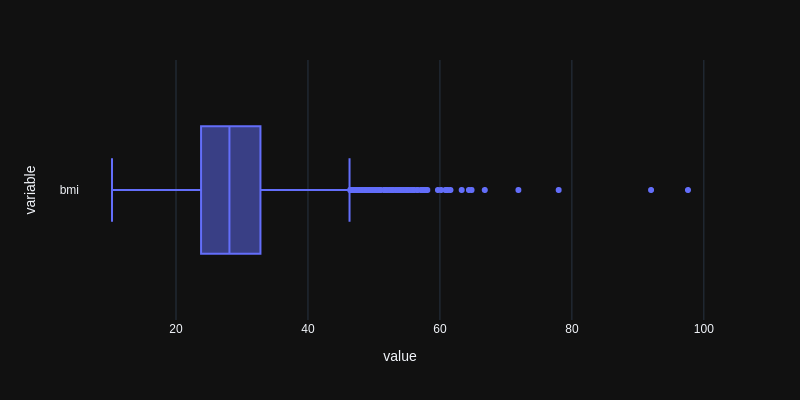

In [63]:
fig = px.box(df.bmi, orientation= 'h')
fig.update_layout(height=400, width=800, template="plotly_dark")
fig.show('png')

O indice de massa corporal das pessoas que tiveram infarto e das que nao tiveram são em média muito semelhante quando se trata desta amostra.

In [64]:
spark.sql("select stroke, avg(bmi) from dataView group by stroke").show()

+------+------------------+
|stroke|          avg(bmi)|
+------+------------------+
|     1|30.090361445783156|
|     0|28.799115408352275|
+------+------------------+



In [65]:
bmi_stroke1 = spark.sql('SELECT bmi from dataView where stroke == 1').toPandas()
bmi_stroke0 = spark.sql('SELECT bmi from dataView where stroke == 0').toPandas()

Fazendo o teste estatístico confirmamos que há diferença de média da massa corporal entre quem teve AVC e quem não teve.

In [66]:
test_mean(bmi_stroke1, bmi_stroke0, 'two-sided', alpha = 0.05)

The null hypothesis can be rejected. The means are not igual.


Falta apenas salvar o arquivo "limpo".

In [68]:
data_modi.coalesce(1).write.format("csv").mode("overwrite").option("header", "true").save("/content/drive/MyDrive/base_de_dados/Stroke-data/Clean-Stroke-data.csv")
